# Learning the Keras functional API

<a id = 'top'></a>

  * A. [Intro to the Functional API](#introToFunctionalKeras)
  * B. [A word about word embeddings](#wordAboutEmbeddings)
  * C. [Description of our dataset](#datasetDescription)
  * D. [Let's Build our functional model](#buildModel)
  * E. [Let's Train and Evaluate our model](#trainModel)
  * F. [Considerations for further exploration](#furtherExploration)
  * G. [A More Complex Architecture](complexArch)
  * H. [Some Rudimentary Analysis](someAnalysis)

<a id = 'introToFunctionalKeras'></a>
## A. Intro to the Functional API
The Keras functional syntax for models is only slightly different from the sequential syntax.  It is an intuitive way to build up model graphs.  In return it offers much greater flexibility, allowing multiple connections from arbitrary layers to other layers.  

It is referred to as "functional" since you use layers as functions called on input nodes to create output nodes.  A good place to start is the [Keras functional documentation](https://keras.io/guides/functional_api/)

Many of the more advanced deep-learning networks you will learn about require layer connections which are not strictly sequential; therefore we will mostly use the functional syntax moving forward.

This notebook gives you a sense of how to use the functional syntax to create a network, even though our example model will end up being one where layers are consecutively connected.

[Go to Top](#top)

In [1]:
!pip install gensim --quiet

In [2]:
import nltk
from nltk.corpus import reuters
from nltk.data import find

import numpy as np

import matplotlib.pyplot as plt

import re

#use gensim to get static pre-trained embeddings
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [3]:
#useful analysis tools
from collections import Counter
import seaborn as sns

from pprint import pprint

from sklearn.metrics import classification_report

<a id = 'wordAboutEmbeddings'></a>
## B. A word about word embeddings

This example will use pre-trained word embeddings from [nltk / gensim](https://github.com/nltk/nltk/blob/develop/nltk/test/gensim.doctest)

You will have more chance to work with embedding vectors in a later homework.  If you haven't been exposed to word embeddings (like "word2vec") think of embeddings as a way to represent word meaning in geometric space, allowing us to do things like compare word similarities using vector operations like dot products.  For now, we'll use the word2vec pre-trained model to create an embedding layer for our classifier model.

[Go to Top](#top)

In [4]:
# Download NLTK's sample word2vec embeddings

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

embmod = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)
print('The length of gensim embedding vocabulary : {}'.format(len(embmod)))
EMBEDDING_DIM = len(embmod['university'])
print('Length d of embedding vectors : {}'.format(EMBEDDING_DIM))

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(embmod) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(embmod.key_to_index.keys()):
    embedding_vector = embmod[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

print('The shape of our embedding matrix is {}'.format(embedding_matrix.shape))

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


The length of gensim embedding vocabulary : 43981
Length d of embedding vectors : 300
The shape of our embedding matrix is (43982, 300)


<a id = 'datasetDescription'></a>
## C. Description of our dataset

We will create a classifier model on the [large movie review dataset from Stanford AI Lab](https://ai.stanford.edu/~amaas/data/sentiment/).

This dataset was used in the paper:  
[Learning Word Vectors for Sentiment Analysis by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, Christopher Potts from the Jun 2011 issue of ACL.](https://www.aclweb.org/anthology/P11-1015.pdf)  

The dataset training samples are split between:
  * "negative" movie reviews, with ratings in the range (1,2,3,4) and
  * "positive reviews in the range of (7,8,9,10).

We will re-group the ratings into 2 "negative" groups and 2 "positive" groups, to make our classification task a bit easier.

[Go to Top](#top)

In [5]:
# Download the dataset
import requests
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
r = requests.get(url, allow_redirects=True)
print('Finished downloading file')
open('aclImdb_v1.tar.gz', 'wb').write(r.content)

# Untar the downloaded file
!tar xfz aclImdb_v1.tar.gz
print('Finished untar-ing file')

input_length = 100
import os
import re
pos_directory = "./aclImdb/train/pos/"
neg_directory = "./aclImdb/train/neg/"

# The original labels are negative in [1,2,3,4] and 'positive in [7,8,9,10]'
# To simplify our classification let's reduce the number of classes by remapping ratings:
#     Map labels to new labels
#      1, 2  map to 0
#      3, 4 map to 1
#      7, 8  map to 2
#      9, 10 map to 3
maplabels = {"1" : 0, "2" : 0,
             "3" : 1, "4" : 1,
             "7" : 2, "8" : 2,
             "9" : 3, "10" : 3}

# Create pos and neg training samples by tokenizing the first 100 words from each review
pos_samples = []
pos_labels = []

#convert the actual words into integer ids so the corresponding embedding can be used
#we'll do it separately for both positive and negative reviews
pat = re.compile('\d+_(\d+).txt')
for file in os.listdir(pos_directory):
    with open(pos_directory + file, 'r') as fh:
        review = fh.readline().split()
        if len(review) < input_length:
            whole = int(input_length / len(review) )
            leftover = len(review) % input_length
            review = review * whole + review[:leftover]
        tokens = [vocab_dict.get(word, 43981) for word in review[:input_length]] # only take the first input_length words
        pos_samples.append(tokens)
        label = pat.sub(r'\1', file) # Extract label from filename
        pos_labels.append(maplabels[label])

neg_samples = []
neg_labels = []
for file in os.listdir(neg_directory):
    with open(neg_directory + file, 'r') as fh:
        review = fh.readline().split()
        if len(review) < input_length:
            whole = int(input_length / len(review) )
            leftover = len(review) % input_length
            review = review * whole + review[:leftover]
        tokens = [vocab_dict.get(word, 43981) for word in review[:input_length]]
        neg_samples.append(tokens)
        label = pat.sub(r'\1', file) # Extract label from filename
        neg_labels.append(maplabels[label])

# Create x samples and labels
from sklearn.model_selection import train_test_split

xsamples = pos_samples + neg_samples # combine lists
# labels = [1] * len(pos_samples) + [0] * len(neg_samples)
labels = pos_labels + neg_labels

# Repackage as numpy arrays
xsamples = np.array(xsamples)
labels = np.array(labels).reshape([-1,1]) # Labels must have at least one column

# Create training, eval split
train_input, test_input, train_labels, test_labels = train_test_split(xsamples, labels, test_size = 0.2,
                                                         random_state = 41,
                                                         shuffle = True)

# Investigate the unique class "levels"
print('Our unique class labels are: {}'.format(np.unique(labels)))


Finished downloading file
Finished untar-ing file
Our unique class labels are: [0 1 2 3]


Let's look at one of our converted training records.  It should consist of integer ids between 0 and 43981.

In [6]:
train_input[0]

array([12730, 19334,  6416,  9511, 43981, 28141, 20514, 43981, 12139,
       25725, 42921, 31696, 25814, 25266, 39090, 43981, 43981, 26960,
       39933, 43981, 43981, 43981, 43981,  4038,  2566,  1331, 14193,
       39933, 43981, 33302, 43981, 43981, 43981, 43981, 16908, 43981,
       30110, 37578, 43981, 42934, 43981,  2326,  7841, 19666,  6909,
        1331,  1493, 43981, 15402, 23158, 43981, 14193, 34177,   275,
       43981,  1334, 16909, 43981, 43981, 43981, 43981, 43981, 43981,
       42952, 23703,  3636, 14276, 43981, 43981, 15402, 43981, 37488,
        3636, 25718, 26925,    33, 43981, 43981,  2326,  3636, 14931,
       42934, 40583,  1331, 33458, 42107, 40418, 43981, 30968, 25272,
       26925, 10490, 43981, 43981,   517, 39985, 38439, 25582, 42909,
       16915])

Let's look for possible class imbalance.  Ideally we want roughly the same number of traiing samples in each class.

In [7]:
ltrain = len(train_labels)
print('Number of training samples = {}'.format(ltrain))
for i in range(4):
    nclass = len(np.where(train_labels.reshape([-1]) == i)[0])
    print('class ' + str(i) + ' has {} samples ({:.2f}%)'.format(nclass, 100 * float(nclass / ltrain )))

print()
ltest = len(test_labels)
print('Number of test samples = {}'.format(ltest))
for i in range(4):
    nclass = len(np.where(test_labels.reshape([-1]) == i)[0])
    print('class ' + str(i) + ' has {} samples ({:.2f}%)'.format(nclass, 100 * float(nclass / ltest )))

Number of training samples = 20000
class 0 has 5874 samples (29.37%)
class 1 has 4120 samples (20.60%)
class 2 has 4373 samples (21.87%)
class 3 has 5633 samples (28.17%)

Number of test samples = 5000
class 0 has 1510 samples (30.20%)
class 1 has 996 samples (19.92%)
class 2 has 1132 samples (22.64%)
class 3 has 1362 samples (27.24%)


<a id = 'buildModel'></a>
## D. Let's build our functional model
Building up a network involves using layers as functions and calling those functions on input tensors to create output tensors, which then can be used to feed other layers.

For example, you can create an input and output connection using a dense layer by doing the following:

  * x = Dense(50, activation='relu')(x)

or by declaring the layer separately and then calling that layer as a function with input, x:

  * dlayer = Dense(50, activation='relu')  
  * x = dlayer(x)

In the second representation, you can see that layer instances resemble functions called on graph nodes.

Now we need to create our embedding matrix.  We'll populate it with the embedding values we downloaded from the nltk sample of word2vec. The embedding matrix will take care of converting the integer ids into the corresponding embedding vector.

In [8]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


#  Package our word2vec embedding model as a fixed pre-trained embedding.
#  Note we set the argument "trainable" to False as we don't want to modify our pre-trained
#  ...embedding values during model training.

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            # input_length=input_length,
                            trainable=False)


Now that we've created our first embedding layer, let's build the model adding other layers using the **Functional API**:

In [9]:
# Choose a word length to truncate each movie review
input_length = 100

# Define an input using our input fixed number of words per review sample
input_x = Input(shape = (input_length,), name="input_words")

# Apply embeddings to each word input
x1 = embedding_layer(input_x)

# Use Keras lambda function layer to take the mean of the 100 word vectors
x2 = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))(x1)    # average of embedding vectors

# Continue building the network graph with some hidden layers
x3 = Dense(50, activation='relu', name="hidden1")(x2)   # hidden layer
x4 = Dense(20, activation='relu', name="hidden2")(x3)   # hidden layer

# Our final output classifier layer.  It has 4 outputs (one for each class)
# Because this is a multi-class output we'll use softmax as an activation.
# We want the predictor outputs to always sum to 1 to represent probability.
yhat = Dense(4, activation='softmax', name="output")(x4)   # classification layer

# Define the model by indicating its original input and final output
model = Model(inputs=input_x, outputs=yhat, name="keras_func_model")

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

**Review the output layers, output dimensions, number of weights**

Let's see whether our dimension discussion was correct. Print a model summary:

In [10]:
model.summary()

Model: "keras_func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 50)                15050     
                                                                 
 hidden2 (Dense)             (None, 20)                1020      
                                                                 
 output (Dense)              (None, 4)                 84        
                                                                 
Total params: 13210754 (50.40 MB)
Trainable params

The model summary is a useful tool for telling us if we have implemented the network we want.  Note that it gives us a list of layers which are identified by the labels we used in the "name" variable when we defined the layer.  Good labeling can help you more easily confirm the model is doing what you want.

The model summary also indicates the dimension of each layer as well as the number of trainable and non-trainable parameters.  Pay close attention to this information.  Does the mix of trainable and non-trainable parameters agree with what you intended?  In our case, we want the embeddings to remain unmodified during the training process so having a large number of non-trainable parameters makes sense.  Is the number of untrainable parameters equal to the number of parameters in the Embedding layer?

<a id = 'trainModel'></a>
## E. Let's Train and Evaluate our model

[Return to Top](#top)

Note that we are using a validation split of 80/20, meaning that we will automatically divide the training data into two groups -- one for learning and one for validation.  We created a test set earlier but we are setting that aside for later testing.  Every time you run use this training data for learning you will get a different set of records in training and validation.

In [11]:
# Train the model
history = model.fit(train_input, train_labels, batch_size = 400, validation_split=0.2, epochs = 30)

Epoch 1/30
40/40 [==============================] - 6s 9ms/step - loss: 1.3742 - sparse_categorical_accuracy: 0.3146 - val_loss: 1.3660 - val_sparse_categorical_accuracy: 0.3512
Epoch 2/30
40/40 [==============================] - 0s 4ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.3776 - val_loss: 1.3488 - val_sparse_categorical_accuracy: 0.3952
Epoch 3/30
40/40 [==============================] - 0s 4ms/step - loss: 1.3351 - sparse_categorical_accuracy: 0.3908 - val_loss: 1.3165 - val_sparse_categorical_accuracy: 0.4078
Epoch 4/30
40/40 [==============================] - 0s 5ms/step - loss: 1.2959 - sparse_categorical_accuracy: 0.4145 - val_loss: 1.2730 - val_sparse_categorical_accuracy: 0.4340
Epoch 5/30
40/40 [==============================] - 0s 5ms/step - loss: 1.2490 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.2250 - val_sparse_categorical_accuracy: 0.4688
Epoch 6/30
40/40 [==============================] - 0s 4ms/step - loss: 1.2093 - sparse_categorical_accuracy: 

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


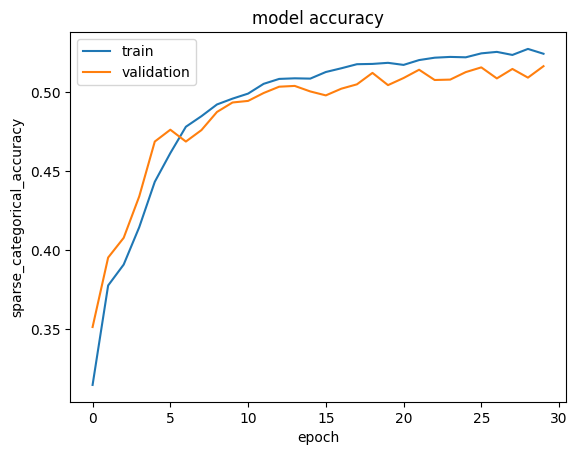

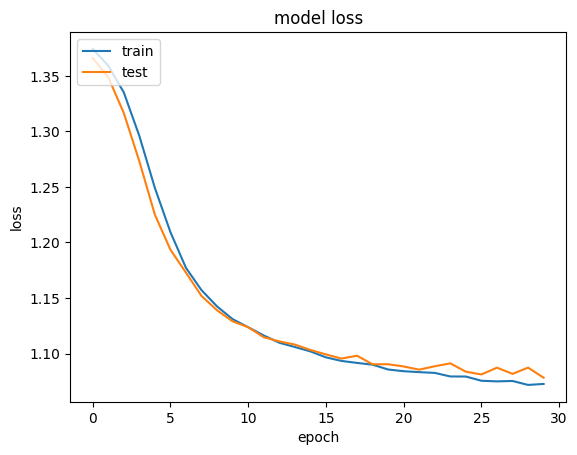

In [12]:
# Plot accuracy and loss for training / validation samples
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

How are our plotted curves looking?  Is the model converging?  


<a id = 'furtherExploration'></a>
## F. Some considerations for further exploration are:
1. What evidence do you see that the above model might be over-fitting?

2. Might BOW have some basic limitations for classification accuracy?  

3. Might the restriction to the first 100 tokens in the review affect classification ccuracy?

4. How might class imbalance impact possible accuracy / bias a model in a particular way to impact accuracy?  How could this be overcome?

5. We are sparse_crossentropy_loss as loss function.  This might not be the optimal loss function.  Can you think of why?

<a id = 'complexArch'></a>
## G. A More Complex Architecture

Now let's construct a contrived complex architecture to demonstrate the possible.  This is the reason we prefer the Keras functional API over the Keras sequential API.  Let's design a model with two outputs that allows us to compare the effect of normalzation and dropout vs. just dropout.  Could we train two separate models and compare them, yes.  However there are times when we want two distinct outputs based on a common origin.  We'll see applicable use cases later in the class.

We'll lay out all of the layers we want and connect them below.  We'll then use the summary() function to make sure all of the layers are properly connected.  We'll use good naming practices to facilitate our checking process.

In [13]:
# Choose a word length to truncate each movie review
input_len = 100
dense_size = 252
drop = 0.3

# Define an input using our input fixed number of words per review
input_x = Input(shape = (input_len,), name="input_words")

# Apply embeddings to each word input
embeds = embedding_layer(input_x)

# Use Keras lambda function layer to take the mean of the 100 word vectors -- this is our averaged network (AN).
avg = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))(embeds)    # average of embedding vectors

# add a droput layer
d1 = tf.keras.layers.Dropout(drop, name="dropout1")(avg)

# add layer normalization layer
n1 = tf.keras.layers.LayerNormalization(name="normalization1")(avg)

# Continue building the network graph
hd1 = Dense(dense_size, activation='relu', name="hiddendrop1")(d1)   # hidden layer - dropout side

# Continue building the network graph
hn1 = Dense(dense_size, activation='relu', name="hiddennorm1")(n1)   # hidden layer - dropout side

# add a droput layer
d2 = tf.keras.layers.Dropout(drop, name="dropout2")(hd1)   #dropout for dropout side

# add a droput layer
dn2 = tf.keras.layers.Dropout(drop, name="normdrop2")(hn1)  #dropout for normalization and dropout side

# Continue building the network graph
hd2 = Dense(dense_size, activation='relu', name="hiddendrop2")(d2)   # hidden layer - dropout side

# Continue building the network graph
hn2 = Dense(dense_size, activation='relu', name="hiddennorm2")(dn2)   # hidden layer - dropout normalization side

d_yhat = Dense(4, activation='softmax', name="drop_output")(hd2)   # classification layer - dropout side
dn_yhat = Dense(4, activation='softmax', name="dropnorm_output")(hn2)   # classification layer - dropout normalization

# use actual 2 layers as model outputs to see the effect of the layer normalization and dropout versus dropout only.
# Note that the model outputs includes dyhat AND dnyhat
func_model_complex_arch = tf.keras.models.Model(inputs=[input_x], outputs=[d_yhat, dn_yhat])



Now let's compile the model to see if we've written the code properly. Note that we are indicating we want to measure the loss and the accuracy on each of the outputs.

In [14]:
# Compile the model
func_model_complex_arch.compile(optimizer='adam',
              loss={'drop_output':'sparse_categorical_crossentropy', 'dropnorm_output':'sparse_categorical_crossentropy'},
              metrics = {'drop_output': 'accuracy', 'dropnorm_output': 'accuracy'}
)

How can we make sure we've connected our layers together properly.  Just because our model compiles doesn't mean that we've properly connected the layers.  It just means some of the layers are connected. We can clearly see the layers we're using and how they are connected.  This is also a good way to see not only ther total number of parameters in the model but also a count of the trainable and the non-trainable paramters.  Did you mean for those parameters in that layer to be frozen?

In [15]:
func_model_complex_arch.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_words (InputLayer)    [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             1319460   ['input_words[0][0]']         
                                                          0                                       
                                                                                                  
 lambda_1 (Lambda)           (None, 300)                  0         ['embedding[1][0]']           
                                                                                                  
 dropout1 (Dropout)          (None, 300)                  0         ['lambda_1[0][0]']        

Another way of viewing the structure of your model is to use the keras function `plot_model` which generates a nice graphic image of the architecture.  Let's look at our contrived model and see what it looks like.

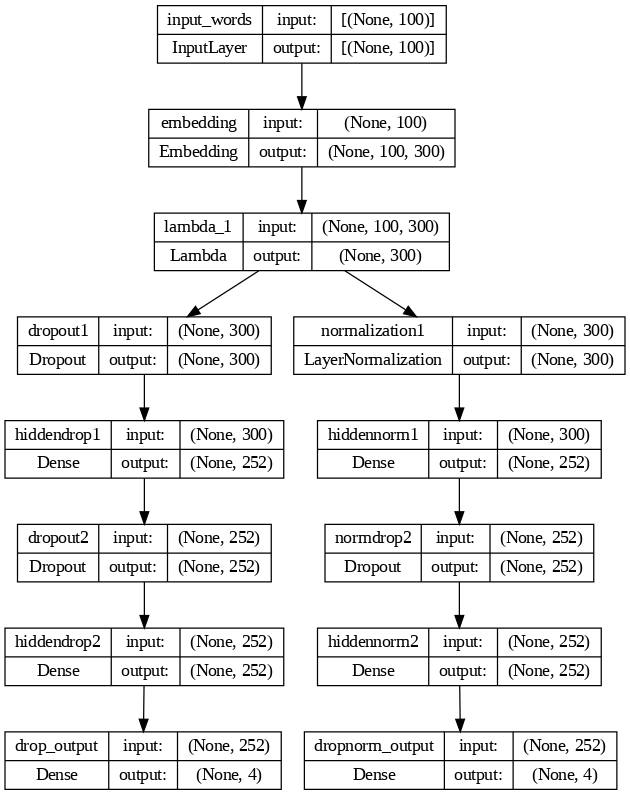

In [16]:
keras.utils.plot_model(func_model_complex_arch, show_shapes=True, dpi=90)

Does the plot model diagram look like what we want?  What do the dimensions look like?  Have we connected our layers together properly?


Okay, let's train the model.

In [17]:
# Train the model
complex_history = func_model_complex_arch.fit(train_input, train_labels, batch_size = 400, validation_split=0.2, epochs = 15)

Epoch 1/15
40/40 [==============================] - 3s 13ms/step - loss: 2.6518 - drop_output_loss: 1.3649 - dropnorm_output_loss: 1.2869 - drop_output_accuracy: 0.3343 - dropnorm_output_accuracy: 0.3971 - val_loss: 2.5064 - val_drop_output_loss: 1.3372 - val_dropnorm_output_loss: 1.1692 - val_drop_output_accuracy: 0.3842 - val_dropnorm_output_accuracy: 0.4753
Epoch 2/15
40/40 [==============================] - 0s 7ms/step - loss: 2.4681 - drop_output_loss: 1.2998 - dropnorm_output_loss: 1.1683 - drop_output_accuracy: 0.3972 - dropnorm_output_accuracy: 0.4721 - val_loss: 2.3749 - val_drop_output_loss: 1.2348 - val_dropnorm_output_loss: 1.1401 - val_drop_output_accuracy: 0.4370 - val_dropnorm_output_accuracy: 0.4800
Epoch 3/15
40/40 [==============================] - 0s 5ms/step - loss: 2.3653 - drop_output_loss: 1.2327 - dropnorm_output_loss: 1.1326 - drop_output_accuracy: 0.4342 - dropnorm_output_accuracy: 0.4936 - val_loss: 2.2994 - val_drop_output_loss: 1.1723 - val_dropnorm_output_

<a id = 'someAnalysis'></a>
## H. Some Rudimentary Analysis
Why are we seeing these results.  An accuracy around 50% is not great.  If we predicted the most common class our accuracy would be around 30%, so we know our model is learning.  Let's look at two tools, the classification report and the confusion matrix to begin to dig below the surface.

First, we're looking at the overall loss but we really need to see the values for each output.  We're trying to find out if dropout plus normalization is better than just dropout alone.

Now we'll use the test set we set aside earlier to see how well the model is performing.  Specifically we'll use the evaluate method to pass our test records through the trained model and measure how well it does. Since our model has two outputs we'll want to see how each one of them is performing.  When we compiled the model we indicated we wanted to do so.


In [18]:
# Test the model with evaluate and print loss and and accuracy for both outputs
loss,dhat_loss,dnhat_loss,dhat_acc,dnhat_acc=func_model_complex_arch.evaluate(x=test_input, y=test_labels)
print()
print(f'loss: {loss}')
print(f'drop_loss: {dhat_loss}')
print(f'dropnorm_loss: {dnhat_loss}')
print(f'drop_accuracy: {dhat_acc}')
print(f'dropnorm_accuracy: {dnhat_acc}')

157/157 [==============================] - 1s 3ms/step - loss: 2.1821 - drop_output_loss: 1.1093 - dropnorm_output_loss: 1.0728 - drop_output_accuracy: 0.5120 - dropnorm_output_accuracy: 0.5270

loss: 2.1820924282073975
drop_loss: 1.109339714050293
dropnorm_loss: 1.072751522064209
drop_accuracy: 0.5120000243186951
dropnorm_accuracy: 0.5270000100135803


Interesting.  It looks like the dropout and normalization is performing slightly better than just the dropout.  Let's see if we can get some more clarity.

First let's assign labels to our classes -- 0, 1, 2, and 3.

In [19]:
target_names =['vneg', 'neg', 'pos', 'vpos']

We'll use the predict method to run our set aside test data and capture the results for a more detailed examination.  Specifically, we'll capture the predictions made by both outputs.  Take a look at the shape of the output.  We have an array for of the model outputs.

In [20]:
predictions_model1 = func_model_complex_arch.predict(test_input)
drop_preds = predictions_model1[0]
dropnorm_preds = predictions_model1[1]

157/157 [==============================] - 0s 2ms/step


How are we doing when we only use dropout?

In [21]:
drop_preds_max = tf.argmax(drop_preds, axis=-1)

The Scikit Learn Classification Report shows the precision and recall for each class.  You should already understand what these metrics (precision, recall, F-1) mean.

In [22]:
print(classification_report(test_labels, drop_preds_max.numpy()))

              precision    recall  f1-score   support

           0       0.56      0.73      0.64      1510
           1       0.39      0.20      0.26       996
           2       0.43      0.31      0.36      1132
           3       0.53      0.67      0.59      1362

    accuracy                           0.51      5000
   macro avg       0.48      0.48      0.46      5000
weighted avg       0.49      0.51      0.49      5000



The confusion matrix shows us how often the model made the correct prediction and what class it predicted when it was wrong.  An ideal confusion matrix has a sharp diagonal line indicating the model always chose the correct class.  More often, we see confusion between specific classes.

In [23]:
cm = tf.math.confusion_matrix(test_labels, drop_preds_max)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(20.72222222222222, 0.5, 'True')

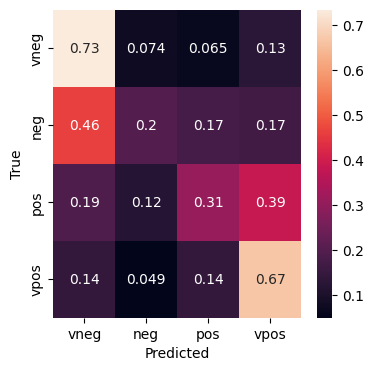

In [24]:
plt.figure(figsize=(4,4))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

We can see that the model does better at predicting the extreme classes -- vneg and vpos -- when relying on dropout.

Does having normalization with the dropout help improve further?  Let's first look at the classification report.

In [25]:
dropnorm_preds_max = tf.argmax(dropnorm_preds, axis=-1)

In [26]:
print(classification_report(test_labels, dropnorm_preds_max.numpy()))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63      1510
           1       0.41      0.35      0.38       996
           2       0.44      0.37      0.40      1132
           3       0.53      0.68      0.60      1362

    accuracy                           0.53      5000
   macro avg       0.51      0.51      0.50      5000
weighted avg       0.52      0.53      0.52      5000



Now let's produce the Confusion Matrix for the output using **BOTH** normalization and dropout.

In [27]:
cm2 = tf.math.confusion_matrix(test_labels, dropnorm_preds_max)
cm2 = cm2/cm2.numpy().sum(axis=1)[:, tf.newaxis]

Text(20.72222222222222, 0.5, 'True')

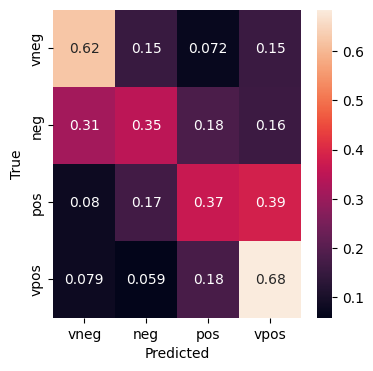

In [28]:
plt.figure(figsize=(4,4))
sns.heatmap(
    cm2, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

A cursory comparison between the two outputs seems to indicate that dropout alone produces slightly better results than a combination of dropout and normalization.  In both cases the seems to have some difficult distinguishing between the very positive and positive as well as between the very negative and negative.  This can happen for a variety of reasons one of which may be how we aggregated the training and test data into a four classes.  We'll explore that type of analysis later in the class.